In [1]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import run_nerf_helpers


### Load trained network weights
Run `bash download_example_weights.sh` in the root directory if you need to download the Lego example weights

Args:
expname = miaxmo_14_1_1_cl_no8020_z_cl_depth_test
basedir = ./logs
datadir = ./data/nerf_synthetic/miaxmo_14_1_1_cl_no8020_z_cl_depth
dataset_type = blender

half_res = False
no_batching = True

N_samples = 64
N_importance = 64

use_viewdirs = True

white_bkgd = True

N_rand = 1024

testskip = 1

lrate = 1e-4

use_depth = True
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
Not ndc!
Found ckpts ['./logs/miaxmo_14_1_1_cl_no8020_z_cl_depth_test/model_100000.npy']
Reloading from ./logs/miaxmo_14_1_1_cl_no8020_z_cl_depth_test/model_100000.npy
Resetting step to 100001
Reloading fine from ./logs/miaxmo_14_1_1_cl_no8020_z_cl_depth_test/model_fine_100000.npy
Render kwargs:
{'N_importance': 64,
 'N_samples': 64,
 'far': <tf.Tensor: id=927, shape=(), dtype=float32, numpy=6.0>,
 'lindisp': False,
 'ndc': False,
 'near': <tf.Tensor: id=926, shape=(), dtype=float32, numpy=2.0>,
 'network_fine': <tensorfl

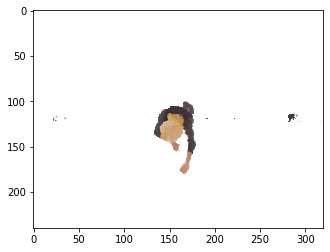

In [2]:
basedir = './logs'
expname = 'miaxmo_14_1_1_cl_no8020_z_cl_depth_test'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()
ft_str = '' 
ft_str = '--ft_path {}'.format(os.path.join(basedir, expname, 'model_100000.npy'))
args = parser.parse_args('--config {} '.format(config) + ft_str)

# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(2., tf.float32),
    'far' : tf.cast(6., tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)

# Render an overhead view to check model was loaded correctly
c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
c2w[2,-1] = 4.
H, W, focal = 480, 640, 470.
down = 2
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_test)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

### Query network on dense 3d grid of points

(257, 257, 257, 3)
(257, 257, 257, 4)


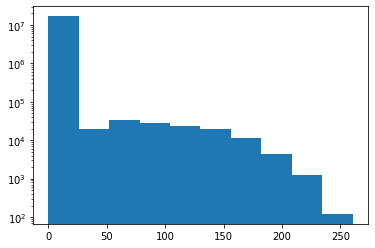

In [3]:
N = 256
t = np.linspace(-1, 1, N+1)

query_pts = np.stack(np.meshgrid(t, t, t+1), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = query_pts.reshape([-1,3])


def batchify(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret
    
    
fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:], viewdirs=np.zeros_like(flat[i0:i1]), network_fn=render_kwargs_test['network_fine'])
chunk = 1024*64
raw = np.concatenate([fn(i, i+chunk).numpy() for i in range(0, flat.shape[0], chunk)], 0)
raw = np.reshape(raw, list(sh[:-1]) + [-1])
sigma = np.maximum(raw[...,-1], 0.)

print(raw.shape)
plt.hist(np.maximum(0,sigma.ravel()), log=True)
plt.show()

### Marching cubes with [PyMCubes](https://github.com/pmneila/PyMCubes)
Change `threshold` to use a different sigma threshold for the isosurface

In [4]:
import mcubes

threshold = 50.
print('fraction occupied', np.mean(sigma > threshold))
vertices, triangles = mcubes.marching_cubes(sigma, threshold)
print('done', vertices.shape, triangles.shape)

### Uncomment to save out the mesh
mcubes.export_mesh(vertices, triangles, "logs/miaxmo_14_1_1_cl_no8020_z_cl_depth_test/miaxmo_14_1_1_cl_no8020_z_cl_depth_test_{}.dae".format(N), "lego")

fraction occupied 0.007283768158682803
done (62966, 3) (126056, 3)


### Live preview with [trimesh](https://github.com/mikedh/trimesh)
Click and drag to change viewpoint

In [5]:
import trimesh

mesh = trimesh.Trimesh(vertices / N - .5, triangles)
mesh.show()

/home/ICT2000/jyang/anaconda3/envs/nerf/lib/python3.7/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:


### Save out video with [pyrender](https://github.com/mmatl/pyrender)

In [6]:
os.environ["PYOPENGL_PLATFORM"] = "egl"
import pyrender
from load_blender import pose_spherical

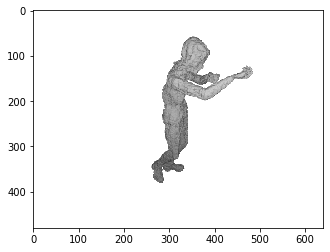

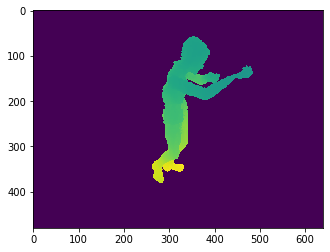

In [7]:
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_trimesh(mesh, smooth=False))

# Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)

camera_pose = pose_spherical(-20., -40., 1.).numpy()
nc = pyrender.Node(camera=camera, matrix=camera_pose)
scene.add_node(nc)

# Set up the light -- a point light in the same spot as the camera
light = pyrender.PointLight(color=np.ones(3), intensity=4.0)
nl = pyrender.Node(light=light, matrix=camera_pose)
scene.add_node(nl)

# Render the scene
r = pyrender.OffscreenRenderer(640, 480)
color, depth = r.render(scene)

plt.imshow(color)
plt.show()
plt.imshow(depth)
plt.show()


In [8]:
imgs = []
for th in np.linspace(0, 360., 120+1)[:-1]:
    camera_pose = pose_spherical(th, -40., 1.).numpy()
    scene.set_pose(nc, pose=camera_pose)
    imgs.append(r.render(scene)[0])
f = 'logs/miaxmo_14_1_1_cl_no8020_z_cl_depth_test/miaxmo_14_1_1_cl_no8020_z_cl_depth_test_turntable.mp4'
imageio.mimwrite(f, imgs, fps=30)
print('done')

done


In [9]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)